In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daigt-proper-train-dataset/train_drcat_03.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_02.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_04.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_01.csv
/kaggle/input/argugpt/argugpt.csv
/kaggle/input/argugpt/machine-dev.csv
/kaggle/input/argugpt/machine-test.csv
/kaggle/input/argugpt/machine-train.csv
/kaggle/input/transformers-model-downloader-pytorch-tf2-0/__results__.html
/kaggle/input/transformers-model-downloader-pytorch-tf2-0/__notebook__.ipynb
/kaggle/input/transformers-model-downloader-pytorch-tf2-0/__output__.json
/kaggle/input/transformers-model-downloader-pytorch-tf2-0/custom.css
/kaggle/input/transformers-model-downloader-pytorch-tf2-0/microsoft/deberta-v3-base/spm.model
/kaggle/input/transformers-model-downloader-pytorch-tf2-0/microsoft/deberta-v3-base/config.json
/kaggle/input/transformers-model-downloader-pytorch-tf2-0/microsoft/deberta-v3-base/tokenizer.json
/kaggle/input/transformer

## Motivation
The project is motivated by **LLM - Detect AI Generated Text** held by Kaggle. <br>
The goal of the competiion is constructing model to distinguish essays writen by students and those generated by LLM

## Import Necessary Library

In [2]:
import torch.nn.functional as F

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
#import spacy
import re
import gc
# ----------
import os

# Import Data
The notebook uses two datasets: **train_essays.csv** and **train_drcat_04.csv**. <br>
**train_essays.csv** is provided by the competition host, while the label is highly imbalanced.<br> **train_drcat_04.csv** is the dataset provided by one of the participants of the competition.

## Train_essays 
Import train_essays.csv as train_essays

In [3]:
train_essays = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/train_essays.csv")
train_essays

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


train_essays is composed of four columns <br>

id - A unique identifier for each essay. <br>

prompt_id - Identifies the prompt the essay was written in response to. <br>

text - The essay text itself. <br>

generated - Whether the essay was written by a student (0) or generated by an LLM (1). This field is the target and is not present in test_essays.csv. <br>

(quoted from the competition host)


#### Prompt id & Generated

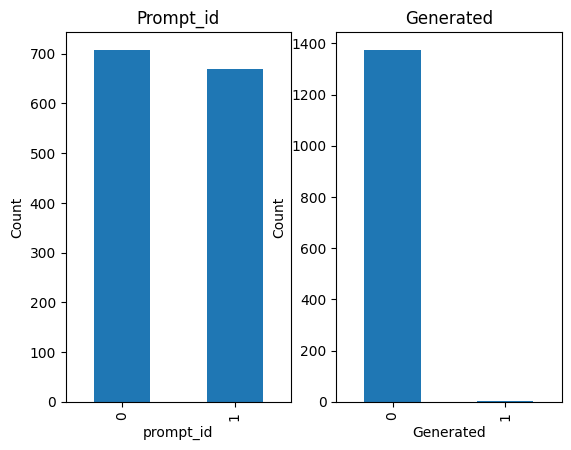

<Figure size 640x480 with 0 Axes>

In [4]:
plt.subplot(1,2,1)
train_essays['prompt_id'].value_counts().plot(kind='bar')
plt.xlabel('prompt_id')
plt.ylabel('Count')
plt.title('Prompt_id')

plt.subplot(1,2,2)
train_essays['generated'].value_counts().plot(kind='bar')
plt.xlabel('Generated')
plt.ylabel('Count')
plt.title('Generated')



# Display the plot
plt.show()

plt.tight_layout()

There are only 1378 essays in the train_essay provided by the host. <br>
There are two prompt_ids, quite balanced in train_essay. <br>
On the other hand, the variable, generated, indicating whether the essay is generated by LLM is highly unbalanced. <br>
Only very few essays are generated by LLMS. <br>
Thus, it motivates me to introduce other datasets constructed by other participants <br>

## External Data

In [5]:
external = pd.read_csv("/kaggle/input/daigt-proper-train-dataset/train_drcat_04.csv")
external

,essay_id,text,label,source,prompt,fold
0,E897534557AF,"In recent years, technology has had a profoun...",1,mistral7binstruct_v2,\nTask: Write an essay discussing the positive...,1
1,DFBA34FFE11D,Should students participate in an extracurricu...,0,persuade_corpus,NaN,2
2,af37ecf5,The electoral college is a symbol of mockery a...,0,train_essays,NaN,5
3,5EC2696BAD78,This is why I think the principle should allow...,0,persuade_corpus,NaN,8
4,llama_70b_v1843,I strongly believe that meditation and mindful...,1,llama_70b_v1,Some schools have implemented meditation and m...,0
...,...,...,...,...,...,...
44201,F7341069C4A4,"""Oh man I didn't make the soccer team!"", yelle...",0,persuade_corpus,NaN,7
44202,AFE6E553DAC2,I believe that using this technology could be ...,0,persuade_corpus,NaN,8
44203,falcon_180b_v1_600,The Face on Mars is a fascinating phenomenon t...,1,falcon_180b_v1,You have read the article 'Unmasking the Face ...,3
44204,A5F84C104693,Texting & Driving\n\nUsing your phone while dr...,0,persuade_corpus,NaN,1


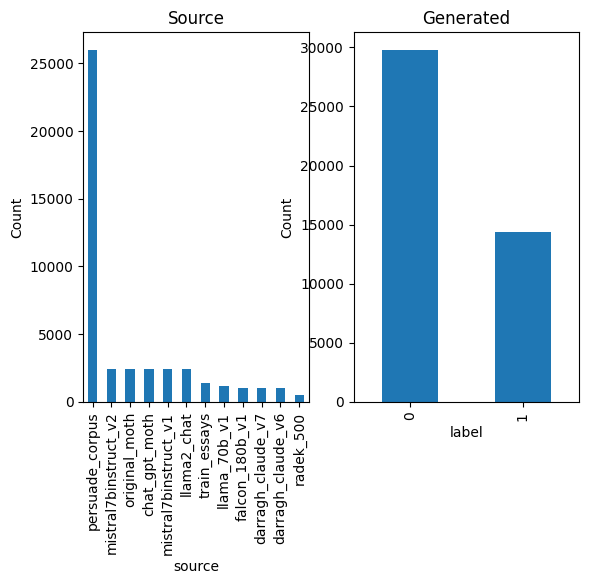

<Figure size 640x480 with 0 Axes>

In [6]:
plt.subplot(1,2,1)
external['source'].value_counts().plot(kind='bar')
plt.xlabel('source')
plt.ylabel('Count')
plt.title('Source')

plt.subplot(1,2,2)
external['label'].value_counts().plot(kind='bar')
plt.xlabel('label')
plt.ylabel('Count')
plt.title('Generated')



# Display the plot
plt.show()

plt.tight_layout()

The dataset is collected by DAREK KŁECZEK, combining other datasets including the train_essays <br>
In total, there are around 30,000 essays writen by students and 15,000 essays generated by LLM.<br>
The variable source suggested that more than 25,000 essays come from "persuaded corpus"(a dataset  comprises over 25,000 argumentative essays produced by 6th-12th grade students in the United States)<br>

To make the label(generated by LLM or not)more balanced, I resample the data, by randomly picking 10000 essays from "persuaded_corpus"

In [7]:
df = pd.concat([
    external[external.source=="persuade_corpus"].sample(10000,random_state = 101),
    external[external.source!='persuade_corpus']
])
df = df.reset_index()

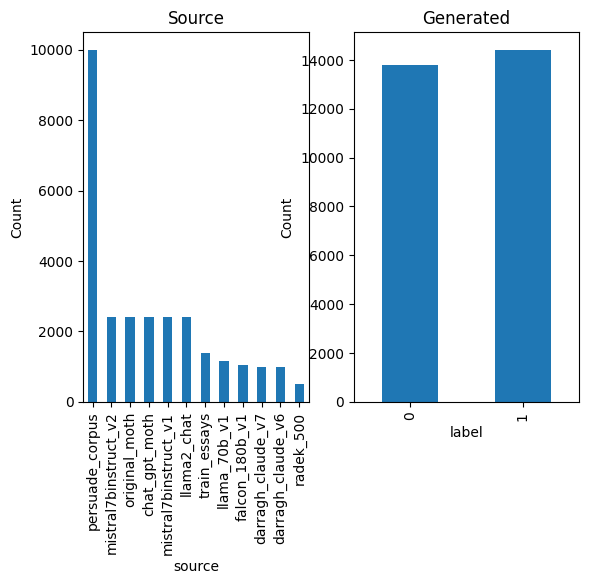

<Figure size 640x480 with 0 Axes>

In [8]:
plt.subplot(1,2,1)
df['source'].value_counts().plot(kind='bar')
plt.xlabel('source')
plt.ylabel('Count')
plt.title('Source')

plt.subplot(1,2,2)
df['label'].value_counts().sort_values().plot(kind='bar')
plt.xlabel('label')
plt.ylabel('Count')
plt.title('Generated')



# Display the plot
plt.show()

plt.tight_layout()

Now, we have balanced labels

## NLP Anlysis

### Word Cloud
Word cloud will give us a first glance of the differences between the common word used by LLM and by Students

In [9]:
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# Download NLTK stopwords
stop_words = set(stopwords.words('english'))

# Function to preprocess and remove stopwords
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens ]
    return tokens
def remove_stpoword(token):
    filtered_tokens   = [word.lower() for word in token if (word.lower() not in stop_words) and (word.lower() not in string.punctuation)]
    return filtered_tokens


df['tokens'] = df['text'].apply(preprocess_text)


In [10]:
df[['text','tokens']]

,text,tokens
0,Have you ever seen or ever been on Mars? Most ...,"[have, you, ever, seen, or, ever, been, on, ma..."
1,"Do you know why people ask for advice, but the...","[do, you, know, why, people, ask, for, advice,..."
2,"In this artical, Driverless cars are coming, t...","[in, this, artical, ,, driverless, cars, are, ..."
3,For many years cars have been one of the top p...,"[for, many, years, cars, have, been, one, of, ..."
4,I think that all students whether they have a ...,"[i, think, that, all, students, whether, they,..."
...,...,...
28205,I think it's a good idea for schools to have o...,"[i, think, it, 's, a, good, idea, for, schools..."
28206,Students often debate whether inactivity or s...,"[students, often, debate, whether, inactivity,..."
28207,The Seagoing Cowboys program is an amazing opp...,"[the, seagoing, cowboys, program, is, an, amaz..."
28208,Advantages of Limiting Car Usage\n\nLimiting c...,"[advantages, of, limiting, car, usage, limitin..."


In [11]:
def gen_word_cloud(df,ai):
    df1 = df.loc[df['label']==ai]
    stop_words = set(stopwords.words('english'))
    df1['without_stop_tokens'] = df1['tokens'].apply(remove_stpoword)
    word_collection = ' '.join([token for tokens in df1['without_stop_tokens'] for token in tokens])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(word_collection)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    if ai==0:
        plt.title('Word Cloud without Stop Words (Student)')
    else:
        plt.title('Word Cloud without Stop Words (AI)')
    plt.show()
    

/tmp/ipykernel_19/2319772828.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['without_stop_tokens'] = df1['tokens'].apply(remove_stpoword)


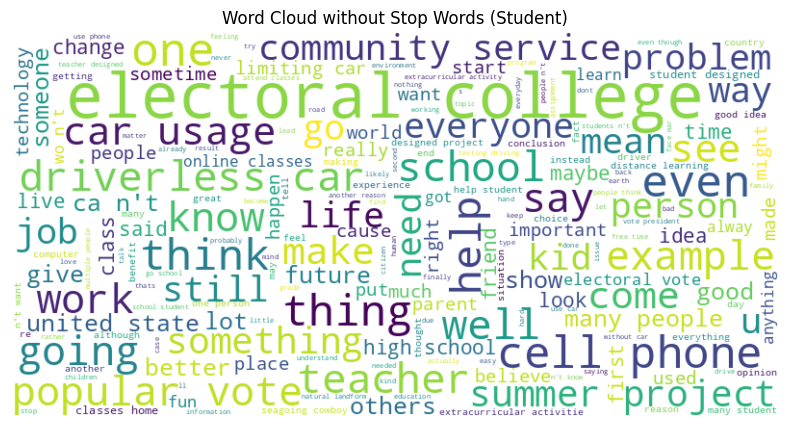

In [12]:
gen_word_cloud(df,0)

/tmp/ipykernel_19/2319772828.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['without_stop_tokens'] = df1['tokens'].apply(remove_stpoword)


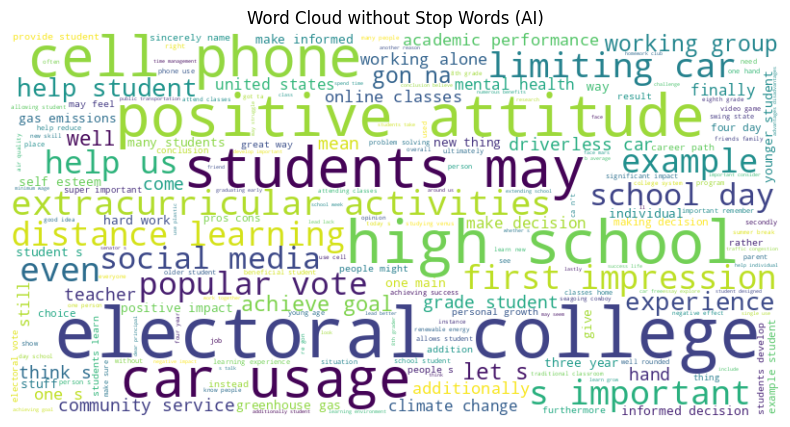

In [13]:
gen_word_cloud(df,1)

The word "eloectoral college" is widely used by both students and LLM. It may be the result of prompt. <br>
One intersting finding is that the term "student", is commonly used by LLM, but not by students. The reasons for this may be that LLMs do not consider themselves as students. Thus, they provide advice for students rather than writing form students prospective. <br>
Another interesting finding is that "positive attitude" is commonly used by LLMs but not by students. 

## Stop Word Analysis

In the previous section, I construct word cloud not including the stop word.<br>
Below is the list of NLTK stop words  {'ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than'} <br>
In this section, I look into the differences in stopwords-using frequency between students and AI <br>
I construct the variable stop word ratio,where $$stop word ratio =\frac{(stop word(token) count)}{token counts} $$

In [14]:
def stopword_count(tokens):
    stopword = [token for token in tokens if token.lower() in stop_words]
    return len(stopword)

df['word_count'] = df['tokens'].apply(len)
df['stopword_count'] = df['tokens'].apply(stopword_count)
df['stopword_ratio'] = df['stopword_count']/df['word_count']   

In [15]:
df

,index,essay_id,text,label,source,prompt,fold,tokens,word_count,stopword_count,stopword_ratio
0,17746,199120B33C77,Have you ever seen or ever been on Mars? Most ...,0,persuade_corpus,NaN,5,"[have, you, ever, seen, or, ever, been, on, ma...",587,269,0.458262
1,40476,533305B42133,"Do you know why people ask for advice, but the...",0,persuade_corpus,NaN,9,"[do, you, know, why, people, ask, for, advice,...",360,179,0.497222
2,25754,6404EE6B025B,"In this artical, Driverless cars are coming, t...",0,persuade_corpus,NaN,0,"[in, this, artical, ,, driverless, cars, are, ...",384,180,0.468750
3,20834,90F15E0EDD83,For many years cars have been one of the top p...,0,persuade_corpus,NaN,3,"[for, many, years, cars, have, been, one, of, ...",502,238,0.474104
4,1656,53CF7CA4FF9B,I think that all students whether they have a ...,0,persuade_corpus,NaN,1,"[i, think, that, all, students, whether, they,...",179,95,0.530726
...,...,...,...,...,...,...,...,...,...,...,...
28205,44190,falcon_180b_v1_261,I think it's a good idea for schools to have o...,1,falcon_180b_v1,Some schools have implemented policies that al...,0,"[i, think, it, 's, a, good, idea, for, schools...",305,142,0.465574
28206,44195,BDF13939FA26,Students often debate whether inactivity or s...,1,mistral7binstruct_v2,\nTask: Research the benefits of staying occup...,3,"[students, often, debate, whether, inactivity,...",313,139,0.444089
28207,44197,1ed36fd42635_04112023,The Seagoing Cowboys program is an amazing opp...,1,darragh_claude_v6,NaN,5,"[the, seagoing, cowboys, program, is, an, amaz...",364,149,0.409341
28208,44199,d8f15f7d,Advantages of Limiting Car Usage\n\nLimiting c...,1,radek_500,NaN,0,"[advantages, of, limiting, car, usage, limitin...",480,157,0.327083


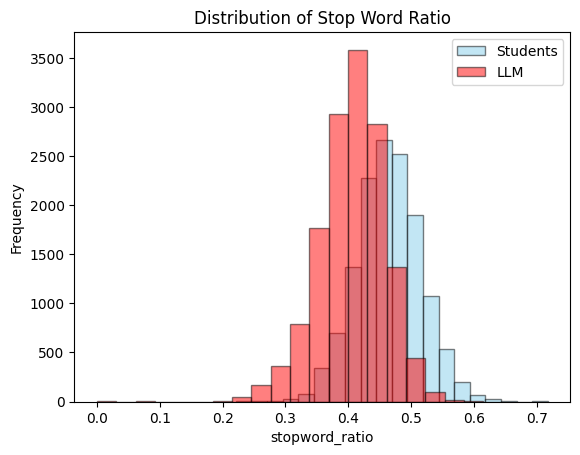

In [16]:
plt.hist(df.loc[df['label'] == 0]['stopword_ratio'], bins=20, color='skyblue', edgecolor='black',alpha=0.5,label='Students')
plt.hist(df.loc[df['label'] == 1]['stopword_ratio'], bins=20, color='red', edgecolor='black',alpha=0.5,label = 'LLM')
plt.xlabel('stopword_ratio')
plt.ylabel('Frequency')
plt.title('Distribution of Stop Word Ratio')
plt.legend()
plt.show()

The graph shows that students use stop word tokens more frequently than LLM

### 

## TFDIF and PCA

This section combine TFDIF and PCA to explore the difference in writing between students and LLM <br>
It is dfferent from the word cloud analysis, where we compare the words commonly used by LLM and those by students<br>
While in this section, I am trying to capture the difference in choice of "word combinations" between LLM and students

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D 

# Create the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the documents
tfidf_matrix = vectorizer.fit_transform(df['text'])

For each word, tfidf value of a student measures the using frequency compared to other students. <br>
Thus, we got a high dimensional data performing tfidf. <br>
To decrease dimension, we use PCA.

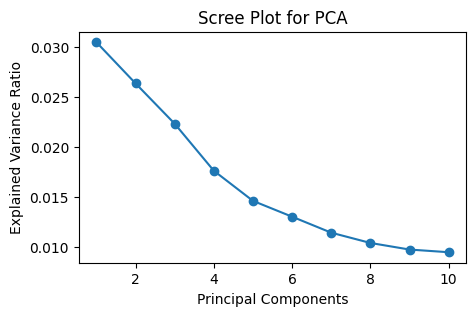

In [18]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray())
n_components = min(len(tfidf_df.columns), 10)
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(tfidf_df)

# Plot the scree plot
plt.figure(figsize=(5, 3))
plt.plot(range(1, n_components + 1), pca.explained_variance_ratio_, marker='o')
plt.title('Scree Plot for PCA')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

The plot suggests that 4 may be a good choice for PCA. <br>
The idea of PCA is to use decrease dimensionality while preserving data variation

In [19]:
pca = PCA(n_components = 4)
pca_tf = pca.fit_transform(tfidf_df)
pca_df = pd.DataFrame(data = pca_tf[:,:3],columns=['PC1', 'PC2', 'PC3'])
pca_df = pd.concat([pca_df,df[['label']]],axis = 1)

Text(0.5, 0.92, 'PCA of tfidf ')

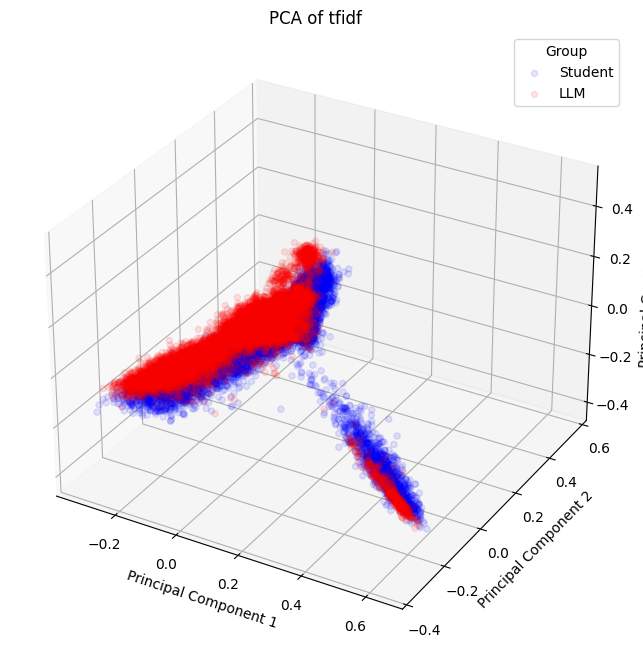

In [20]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df[pca_df['label'] == 0]['PC1'], pca_df[pca_df['label'] == 0]['PC2'], pca_df[pca_df['label'] == 0]['PC3'], c='blue', label='Student', alpha=0.1)

# Scatter plot for Group 1
ax.scatter(pca_df[pca_df['label'] == 1]['PC1'], pca_df[pca_df['label'] == 1]['PC2'], pca_df[pca_df['label'] == 1]['PC3'], c='red', label='LLM', alpha=0.1)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend(title='Group', loc='upper right')
ax.set_title('PCA of tfidf ')


We have more blue dots (students) at the  lower-right, while more red dots at the upper left. <br>

The difference is not obvious, which inspiers me to employ LLM.